# ¿Dónde es más barato ir al restaurant?

## Ejercicio de Web Scraper con BeautifulSoup y Análisis de los Datos

**Planteamiento:** 

La página [PreciosMundi](https://preciosmundi.com/) posee información general y económica de una gran cantidad de países agrupados por continentes, principalemente precios de productos. 

El objetivo es extraer información general sobre los países así como los precios de referencia de algunos productos en restaurantes para los países de América. Se generará un archivo .CSV usando ';' como separador conteniendo los datos extraídos.

Por otro lado, se harán una serie de análisis y de gráficos para determinar en qué país es más barato ir al restaurant.

### Información a extraer:

| **Información** | **Descripción** |
| ------------- | ------------- | 
| pais | Texto |
| moneda | Texto. 3 caracteres |
| euro | Tasa de cambio del euro |
| dolar | Tasa de cambio del dólar (USD) |
| salario | Salario medio mensual |
| poblacion | Población del país |
| capital | Capital del país |
| prducto | Lista de productos de referencia en restaurantes y sus precios* |

*La lista de productos es la que se encuentra en la página. Cada producto será una columna y el valor será el precio

Comparando los precios de cada producto en los diferentes países, podremos determinar en dónde es más barato ir a un restaurant.

In [7]:
import requests
from bs4 import BeautifulSoup
# Para saber el encoding utilizado por el servidor
import chardet

# Leer la página del URL y devolver un objeto BeautifulSoup

def devolver_soup(url):
    # Eliminamos el '/' del final, si existe
    # Da error 403 si se deja
    if url[len(url)-1] == '/':
        url = url[:len(url)-1]
    
    # Obtenemos la página
    try:
        resp = requests.get(url)
    except Exception as e:
        print('Error obteniendo la página. Excepción ',e)
        return url
    
    if resp.status_code != 200:
        print('Error obteniendo la página. Status Code', resp.status_code)
        return url
    
    # Para saber el encoding utilizado por el servidor
    # print(chardet.detect(resp.content))
    
    # Para especificar el tipo de encoding y 
    # obtener correctamente los caracteres acentuados
    resp.encoding = "utf-8"
    contenido = resp.content
    soup = BeautifulSoup(contenido, 'lxml')    

    return soup

In [8]:
import re

# Función general que extrae datos numéricos 
# de una cadena de caracteres. Devuelve un float

# Elimina los "'" y los puntos de mil
# Reemplaza las "," decimales por "."
# Extrae una cifra y la devuelve como float
def extraer_numero(cadena):
    
    result = cadena.replace("'", '').replace('.', '').replace(',', '.')
    
    result = re.findall(r'-?\d+\.?\d*', result)[0]
    
    return float(result)
 
    

In [9]:
from urllib.parse import urlparse

# Extrae el país de la URL

def extraer_pais(url):
    parsed = urlparse(url)
    
    pais = parsed.path.replace('/', '')
    
    return pais
    

# Busca la moneda y las tasas de cambio
# del Euro y del Dólar
def extraer_moneda(soup):
    
    # Compilando la regex
    # Patrones para buscar '1 EUR' y '1 USD'
    ptr_euro = re.compile('1 EUR')  
    ptr_dolar = re.compile('1 USD')
    
    dic = {}
    
    i = soup.text.index('/')
    
    moneda = soup.text[i-4:i-1]
    
    tasas = soup.find_all('small')
    
    # Si la tasa de cambio para una moneda no se encuentra
    # es que es la moneda oficial y su valor es 1
    euro = 1
    dolar = 1
    
    for tasa in tasas:
        
        euro = (extraer_numero(tasa.text.strip().replace('1 EUR', '')) if ptr_euro.match(tasa.text) else euro)
        dolar = (extraer_numero(tasa.text.strip().replace('1 USD', '')) if ptr_dolar.match(tasa.text) else dolar)
    
    dic['moneda'] = moneda
    dic['euro'] = euro
    dic['dolar'] = dolar
    
    return dic
    

def extraer_info_pais(soup):
    dic = {}
    
    infos = soup.find('ul', attrs={'class':'list-group-flush'}).find_all('li')
    
    dic = extraer_moneda(infos[0].find('p'))
      
    dic['salario'] = extraer_numero(infos[1].text.strip())
    dic['poblacion'] = extraer_numero(infos[2].text.strip())
    dic['capital'] = infos[3].text.strip().replace('Capital ', '')
    
    return dic
    

def extraer_info_productos(soup, moneda):
    productos = soup.find_all('tr')
    dic = {}
    
    for producto in productos:
        
        # Recuperamos el nombre del producto y el precio en dólares
        nombre = producto.find('td', class_='product-name')
        precios = producto.find_all('td', class_='price')

        # Para no tratar el encabezado
        if None in (nombre, precios): continue
        
        # Extraemos los precios en dólares
        # que están siempre en la 2da columna,
        # a menos que el dólar o el euro sea la moneda oficial,
        # entonces están el la 1ra columna
        if moneda == 'USD' or moneda == 'EUR':
            precio = precios[0] 
        else:
            precio = precios[1]
 
        # El nombre del producto en la clave, el precio el valor
        dic[nombre.text.strip().replace(',', '.')] = extraer_numero(precio.text.strip().replace('$', '')) 
        
    return dic


### Main del Scraper



In [10]:
# Extraemos los links para los países de América

URL='https://preciosmundi.com/america/'

soup = devolver_soup(URL)

# La página muestra la lista de países en varios bloques
# Debemos recuperar los links para todos los países de
# todos los bloques
bloques_paises = soup.find('div', attrs={'class':'row'}).find_all('ul')

links_paises = []

for bloque in bloques_paises:
    links = bloque.find_all('a')
    for link in links:
        url = link.get('href')
        links_paises.append(url)
        

In [11]:
resultado = []

# Extraemos la información para cada país
# y los precios en los restaurantes

# El resultado es una lista de diccionarios
# Cada diccionario contiene la información de un país
for link in links_paises:
        
    dic_pais = {}
    
    pais = extraer_pais(link)
    
    print("Tratando País:", pais)
    url = link + 'precio-restaurantes'
    soup_pais = devolver_soup(url)

    info_pais = extraer_info_pais(soup_pais)
    info_productos = extraer_info_productos(soup_pais, info_pais['moneda'])
    
    dic_pais = dict(info_pais, **info_productos)
    
    dic_pais['url'] = link
    dic_pais['pais'] = pais
    
    print(dic_pais)
    
    resultado.append(dic_pais)

Tratando País: argentina
{'moneda': 'ARS', 'euro': 116.463, 'dolar': 102.696, 'salario': 402.16, 'poblacion': 40117096.0, 'capital': 'Buenos Aires', 'Agua (botella de 33 cl)': 0.82, 'Coca-Cola / Pepsi (botella de 33cl)': 1.11, 'Café Cappuccino': 1.63, 'Cerveza importada (botella de 33cl)': 1.95, 'Cerveza nacional (0.5 litros)': 1.5, 'Menú de McDonalds. Burger King o similar': 6.04, 'Comida para dos en restaurante a la carta (dos platos y postre)': 29.21, 'Comida en un restaurante barato (menú del día)': 7.01, 'url': 'https://preciosmundi.com/argentina/', 'pais': 'argentina'}
Tratando País: bolivia
{'moneda': 'BOB', 'euro': 7.793, 'dolar': 6.871, 'salario': 480.25, 'poblacion': 10027254.0, 'capital': 'Sucre', 'Agua (botella de 33 cl)': 0.71, 'Coca-Cola / Pepsi (botella de 33cl)': 0.81, 'Café Cappuccino': 2.55, 'Cerveza importada (botella de 33cl)': 2.91, 'Cerveza nacional (0.5 litros)': 2.08, 'Menú de McDonalds. Burger King o similar': 6.55, 'Comida para dos en restaurante a la carta (d

{'moneda': 'MXN', 'euro': 23.243, 'dolar': 20.495, 'salario': 556.23, 'poblacion': 112336538.0, 'capital': 'Ciudad de México', 'Agua (botella de 33 cl)': 0.63, 'Coca-Cola / Pepsi (botella de 33cl)': 0.85, 'Café Cappuccino': 2.26, 'Cerveza importada (botella de 33cl)': 2.93, 'Cerveza nacional (0.5 litros)': 1.46, 'Menú de McDonalds. Burger King o similar': 5.86, 'Comida para dos en restaurante a la carta (dos platos y postre)': 29.28, 'Comida en un restaurante barato (menú del día)': 5.86, 'url': 'https://preciosmundi.com/mexico/', 'pais': 'mexico'}
Tratando País: nicaragua
{'moneda': 'NIO', 'euro': 40.014, 'dolar': 35.284, 'salario': 263.57, 'poblacion': 6071045.0, 'capital': 'Managua', 'Agua (botella de 33 cl)': 0.78, 'Coca-Cola / Pepsi (botella de 33cl)': 0.83, 'Café Cappuccino': 2.13, 'Cerveza importada (botella de 33cl)': 2.49, 'Cerveza nacional (0.5 litros)': 1.21, 'Menú de McDonalds. Burger King o similar': 5.95, 'Comida para dos en restaurante a la carta (dos platos y postre)': 

### Generación del archivo CSV

In [54]:
import pandas as pd
import datetime 

# Transformamos el resultado en un DataFrame
# para facilitar la generación del archivo CSV
df_restaurant = pd.DataFrame(resultado)

print(df_restaurant)

hoy = datetime.datetime.now()
nombre_archivo = '{continente}_{fecha}_paises.csv'.format(continente="America", fecha=hoy.strftime('%Y_%m_%d'))

df_restaurant.to_csv(nombre_archivo, sep=';')

   moneda      euro     dolar  salario    poblacion              capital  \
0     ARS   116.463   102.696   402.16   40117096.0         Buenos Aires   
1     BOB     7.793     6.871   480.25   10027254.0                Sucre   
2     BRL     6.318     5.572   358.96  201032714.0             Brasilia   
3     CAD     1.437     1.267  2762.54   35158304.0               Ottawa   
4     CLP   966.211   852.000   569.72   16634603.0             Santiago   
5     COP  4610.292  4065.338   303.96   47387109.0               Bogotá   
6     CRC   725.475   639.720   757.99    4652459.0             San José   
7     CUC     1.134     1.000    31.20   11242628.0            La Habana   
8     USD     1.134     1.000   470.00   15761731.0                Quito   
9     USD     1.134     1.000   370.00    6328196.0         San Salvador   
10    USD     1.134     1.000  3600.00  316017000.0     Washington D. C.   
11    GTQ     8.722     7.691   468.08   15773517.0  Ciudad de Guatemala   
12    HTG   

### Análisis de los datos

Todos los precios en el Dataset están en dólares US.

In [55]:
df_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 16 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   moneda                                                           23 non-null     object 
 1   euro                                                             23 non-null     float64
 2   dolar                                                            23 non-null     float64
 3   salario                                                          23 non-null     float64
 4   poblacion                                                        23 non-null     float64
 5   capital                                                          23 non-null     object 
 6   Agua (botella de 33 cl)                                          23 non-null     float64
 7   Coca-Cola / Pepsi (botella de 33cl)           

In [53]:
df_resultado.describe()

,euro,dolar,salario,poblacion,Agua (botella de 33 cl),Coca-Cola / Pepsi (botella de 33cl),Café Cappuccino,Cerveza importada (botella de 33cl),Cerveza nacional (0.5 litros),Menú de McDonalds. Burger King o similar,Comida para dos en restaurante a la carta (dos platos y postre),Comida en un restaurante barato (menú del día)
count,23.000000,23.000000,23.000000,2.300000e+01,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,640.128870,564.462391,764.032174,3.988113e+07,0.935217,1.146522,2.377826,3.281739,2.256522,6.555652,35.456957,6.911304
std,1831.740632,1615.219942,846.262517,7.501429e+07,0.463944,0.463991,0.794973,1.187134,1.072481,2.146699,14.245205,3.854323
min,1.134000,1.000000,31.200000,2.735520e+06,0.440000,0.620000,1.080000,1.720000,0.910000,4.430000,17.220000,2.510000
25%,1.285500,1.133500,364.480000,6.199620e+06,0.630000,0.840000,1.775000,2.605000,1.500000,5.610000,25.515000,4.425000
50%,23.243000,20.495000,480.250000,1.008860e+07,0.720000,0.900000,2.320000,3.000000,2.000000,6.000000,30.000000,5.860000
75%,114.894500,101.313000,673.625000,3.281672e+07,1.190000,1.480000,2.735000,3.660000,2.400000,7.015000,42.900000,7.035000
max,7775.566000,6856.453000,3600.000000,3.160170e+08,2.400000,2.320000,4.400000,6.000000,5.000000,15.010000,65.050000,15.010000


In [56]:
# Renombramos las columnas para facilitar el análisis

cols = ['moneda',                                                            
'euro', 
'dolar',                                                            
'salario',
'poblacion',
'capital', 
'agua',
'refresco',
'cafe',
'cerveza imp',
'Cerveza nac',
'hamburguesa',
'carta',
'menu dia',
'url',
'pais']

df_restaurant.columns = cols

df_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   moneda       23 non-null     object 
 1   euro         23 non-null     float64
 2   dolar        23 non-null     float64
 3   salario      23 non-null     float64
 4   poblacion    23 non-null     float64
 5   capital      23 non-null     object 
 6   agua         23 non-null     float64
 7   refresco     23 non-null     float64
 8   cafe         23 non-null     float64
 9   cerveza imp  23 non-null     float64
 10  Cerveza nac  23 non-null     float64
 11  hamburguesa  23 non-null     float64
 12  carta        23 non-null     float64
 13  menu dia     23 non-null     float64
 14  url          23 non-null     object 
 15  pais         23 non-null     object 
dtypes: float64(12), object(4)
memory usage: 3.0+ KB


In [57]:
df_restaurant.head(5)

,moneda,euro,dolar,salario,poblacion,capital,agua,refresco,cafe,cerveza imp,Cerveza nac,hamburguesa,carta,menu dia,url,pais
0,ARS,116.463,102.696,402.16,40117096.0,Buenos Aires,0.82,1.11,1.63,1.95,1.50,6.04,29.21,7.01,https://preciosmundi.com/argentina/,argentina
1,BOB,7.793,6.871,480.25,10027254.0,Sucre,0.71,0.81,2.55,2.91,2.08,6.55,20.23,2.91,https://preciosmundi.com/bolivia/,bolivia
2,BRL,6.318,5.572,358.96,201032714.0,Brasilia,0.54,0.88,1.29,2.67,1.44,5.37,21.36,4.47,https://preciosmundi.com/brasil/,brasil
3,CAD,1.437,1.267,2762.54,35158304.0,Ottawa,1.45,1.80,3.47,5.92,4.74,8.68,59.20,14.21,https://preciosmundi.com/canada/,canada
4,CLP,966.211,852.000,569.72,16634603.0,Santiago,0.99,1.17,2.35,3.52,2.93,5.87,43.43,7.04,https://preciosmundi.com/chile/,chile


### Países donde es más barato comer

In [59]:
min_ham = df_restaurant.hamburguesa.min()
pais_ham = df_restaurant.pais[df_restaurant.hamburguesa == min_ham].tolist()[0]

min_carta = df_restaurant.carta.min()
pais_carta = df_restaurant.pais[df_restaurant.carta == min_carta].tolist()[0]

min_menu = df_restaurant['menu dia'].min()
pais_menu = df_restaurant.pais[df_restaurant['menu dia'] == min_menu].tolist()[0]

print("===============================")
print("PAISES DONDE SE COME MÁS BARATO")
print("===============================\n")

print("El menú hamburguesa más barato: %s, precio: %5.2f $" % (pais_ham, min_ham))
print("El menú a la carta para 2 más barato: %s, precio: %5.2f $" % (pais_carta, min_carta))
print("El menú del día más barato: %s, precio: %5.2f $" % (pais_menu, min_menu))


PAISES DONDE SE COME MÁS BARATO

El menú hamburguesa más barato: colombia, precio:  4.43 $
El menú a la carta para 2 más barato: colombia, precio: 17.22 $
El menú del día más barato: peru, precio:  2.51 $


### Países donde es más caro comer

In [58]:
max_ham = df_restaurant.hamburguesa.max()
pais_ham = df_restaurant.pais[df_restaurant.hamburguesa == max_ham].tolist()[0]

max_carta = df_restaurant.carta.max()
pais_carta = df_restaurant.pais[df_restaurant.carta == max_carta].tolist()[0]

max_menu = df_restaurant['menu dia'].max()
pais_menu = df_restaurant.pais[df_restaurant['menu dia'] == max_menu].tolist()[0]

print("===============================")
print("PAISES DONDE SE COME MÁS CARO")
print("===============================\n")

print("El menú hamburguesa más caro: %s, precio: %5.2f $" % (pais_ham, max_ham))
print("El menú a la carta para 2 más caro: %s, precio: %5.2f $" % (pais_carta, max_carta))
print("El menú del día más caro: %s, precio: %5.2f $" % (pais_menu, max_menu))


PAISES DONDE SE COME MÁS CARO

El menú hamburguesa más caro: haiti, precio: 15.01 $
El menú a la carta para 2 más caro: haiti, precio: 65.05 $
El menú del día más caro: haiti, precio: 15.01 $


### Comparación de precios entre los países

<AxesSubplot:xlabel='carta', ylabel='Count'>

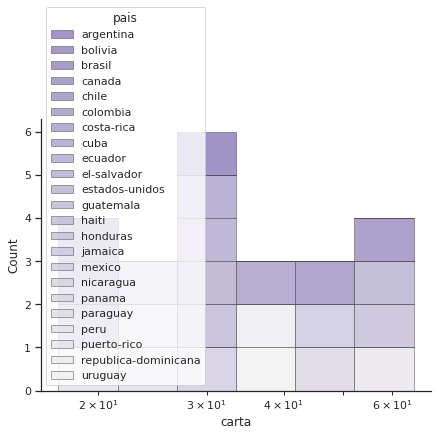

In [68]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    df_restaurant,
    x="carta", hue='pais',
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
#ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_xticks([500, 1000, 2000, 5000, 10000])